In [35]:
using DataFrames
using CSV
using Glob
using Chain
using Statistics
using SimSpread
using ArgParse
using Base.Threads
using MLBase
using ProgressMeter
using AlgebraOfGraphics
using CairoMakie
include("getmetrics.jl")


LoadError: LoadError: ArgParseError("too many arguments")
in expression starting at /home/fabian/Bioinf_2/getmetrics.jl:194

In [3]:
path = "/home/fabian/simspread/simspread_timesplit_predictions"
files = glob("*.out", path)
df = DataFrame()


for file in files
    # extract
    α = @chain file begin
        basename
        replace(".out" => "")
        split('.')
        last
        split('_')
        last
    end
    
    α_value = if startswith(α, "0")
              parse(Float64, α, ) / 100
          else
              parse(Float64, α) / 10
          end
 
    
    # file to df
    file_df = CSV.File(file, delim=",", header=["Fold", "Ligando", "Target", "Score", "TP"]) |> DataFrame
    
    # add alpha 
    file_df[!, "Alpha"] .= α_value
    
    append!(df, file_df)
end




In [4]:
# alpha_values = unique(df[:, "Alpha"])
# alpha_values = sort(alpha_values)



In [6]:
df_2 = df
df_2 = @chain df_2 begin
    groupby([:Fold, :Ligando, :Target, :TP, :Alpha])    
    combine(:Score => sum => :Score)
    unstack(:Alpha, :Score)
    DataFrames.transform(AsTable(5:24) .=>
              ByRow.([mean, maximum, sum]) .=>
              [:Mean, :Max, :Sum])
    select([1,2,3,4,9,25,26,27])
end



Row,Fold,Ligando,Target,TP,0.02,Mean,Max,Sum
,Int64,String15,String15,Float64,Float64?,Float64?,Float64?,Float64?
1,1,CHEMBL1062,CHEMBL1075132,0.0,0.0,4.94711e-6,5.02698e-5,9.89422e-5
2,1,CHEMBL1062,CHEMBL1075145,0.0,0.0,6.18897e-7,5.72355e-6,1.23779e-5
3,1,CHEMBL1062,CHEMBL1075165,0.0,0.0,2.61921e-6,2.20103e-5,5.23842e-5
4,1,CHEMBL1062,CHEMBL1075323,0.0,0.0,1.30208e-6,9.3893e-6,2.60415e-5
5,1,CHEMBL1062,CHEMBL1163125,0.0,0.0,5.68893e-6,4.35057e-5,0.000113779
6,1,CHEMBL1062,CHEMBL1250378,0.0,0.0,3.44353e-6,5.37322e-5,6.88706e-5
7,1,CHEMBL1062,CHEMBL1293224,0.0,0.0,2.32767e-6,1.6584e-5,4.65534e-5
8,1,CHEMBL1062,CHEMBL1293226,0.0,0.0,6.49063e-6,5.93017e-5,0.000129813
9,1,CHEMBL1062,CHEMBL1293267,0.0,0.0,4.11327e-6,3.11141e-5,8.22653e-5


In [10]:
df = DataFrame()
metric_name = ["0.02", "Mean", "Max", "Sum"]
for names in metric_name
    df_t = @chain df_2 begin
        select(["Fold", "Ligando", "Target", "TP" , names])
        rename!(5 => :Score)
    end
    
    df_m = getperformance(df_t)
    df_m.groupid = replace(df_m.groupid, missing => names)
    
    
    append!(df, df_m)
end

df

Row,groupid,AuROC,AuPRC,BEDROC,r20,p20,f1,bacc,acc
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.02,0.783286,0.13993,0.473685,1.0,0.6,0.229549,0.750781,0.993846
2,Mean,0.788326,0.175512,0.491081,1.0,0.5,0.297174,0.750061,0.993862
3,Max,0.794082,0.183231,0.499739,1.0,0.6,0.298108,0.759519,0.993946
4,Sum,0.788326,0.175512,0.491081,1.0,0.5,0.297174,0.750061,0.993862


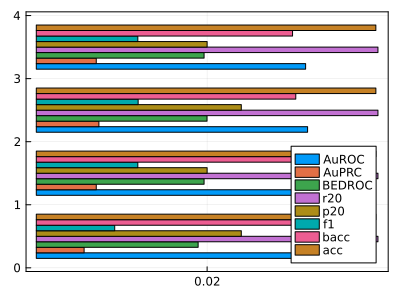

In [98]:
# using Plots
using StatsPlots
gr()
@df df groupedbar(
    :groupid,   
    cols(2:9),
    bar_position = :dodge,
    orientation = :horizontal,
    bar_width=0.7,
    framestyle = :box,
    # group=:groupid
    # label=["AuROC" "AuPRC" "BEDROC" "r20" "p20" "f1" "acc"]
    
)

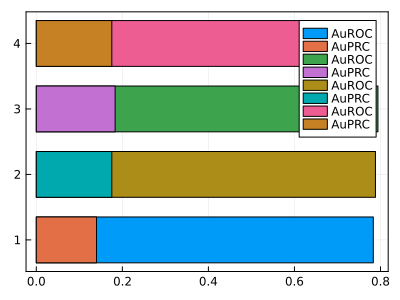

In [89]:
@df df bar(
    cols(2:3),
    # bar_position = :dodge,
    orientation = :horizontal,
    bar_width=0.7,
    framestyle = :box,  
    group=:groupid
    # label=["AuROC" "AuPRC" "BEDROC" "r20" "p20" "f1" "acc"]
    )